# Functions

In [12]:
def print_shape_of_dataframes(**kwargs):
    """
    Print the shape (number of rows and columns) of multiple pandas DataFrame
    objects.

    Parameters:
    -------------
    **kwargs: dict
        Keyword arguments where the keys are the names of the DataFrame
        objects (as string) and the values are the DataFrame objects
        themselves.

    Notes:
    ------------
    The functon dynamically handles any number of DataFrame objects passed
    as keyword arguments.
    Ensure the passed objects are valid pandas DataFrame to avoid unexpected
    errors.
    """
    for name, value in kwargs.items():
        if hasattr(value, 'shape'):
            print(f'DataFrame \033[94m{name.title()}\033[0m has {value.shape[0]} rows and {value.shape[1]} columns.')
            print('------------------------------------')
        else:
            raise ValueError(f'The object 033[94m{name.title()}\033[0m is not a valid DataFrame.')

# 1. Import Libraries

In [13]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


# 2. Import and Read Data

In [14]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_submission = pd.read_csv('data/gender_submission.csv')

In [15]:
df_train[:1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [16]:
df_test[:1]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [17]:
print_shape_of_dataframes(train=df_train, test=df_test)

DataFrame Train has 891 rows and 12 columns.
------------------------------------
DataFrame Test has 418 rows and 11 columns.
------------------------------------


`Train` DataFrame contains 891 rows and 12 columns. This suggests it has more rows, indicating it may represent the primary dataset for model training in a machine learning context. 

`Test` DataFrame has 418 rows and 11 columns. It has fewer rows than `Train`, which is typical in machine learning tasks where the test set is a smaller, unseen dataset used to evaluate the model's performance.

There is a different in the number of columns between `Train` and `Test`. This indicates that the `Test` DataFrame is missing a target column ('Survived'). This is tandard since the test set does not include lavels for avaluation.

# 3. Data Description

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Survived

0 - Did not survive, 1 - Survived

In [19]:
df_train['Survived'].unique()
df_train['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

## Pclass

Ticket class where 1 - First Class, 2 - Second Class, 3 - Third Class.

In [20]:
df_train['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [21]:
df_train['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

## Name

The Name column contains the full names of passengers. Each entry typically include `titles` - `Mr.`, `Mrs.`, `Miss.`, `Master`, or rare titles such as `Dr.`, `Rev`, etc. 

Titles can be extracted to infer age group, marital status, or social class. Surnames can help identify family groups or traveling companions.

## Sex

Male or Female

In [22]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [23]:
df_train['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

## Age

Age in years.

## SibSp

Number of siblings or spouses aboard the titanic

In [24]:
df_train['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [25]:
df_train['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

# 

Parch

Number of parents or children aboard the titanic

In [26]:
df_train['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [27]:
df_train['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

## Ticket

The Ticket column contains the ticket numbers or codes for each passenger. These entries vary in format and can provide interesting details.

## Fare

The Fare column represents the ticket price paid by each passenger. It is a continuous numerical variable and offers valuable insights into passenger economic status. Fare very widely, reflecting differences in passenger class and accommodations. 

## Cabin

The Cabin column contains the cabin number assigned to passengers, indicating their accommodation on the ship. It is a categorical variable, often sparse or incomplete.

## Embarked

Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

In [28]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [29]:
df_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

# 4. EDA (Exploratory Data Analysis)

## 4.1 Data Types, Missing Data and Summary Statistics

In [30]:
def missing_values(data_frame: pd.DataFrame) -> dict:
    """
    Identify missing values in a pandas DataFrame.

    This function calculates the number of missing values in
    each column of the provided DataFrame and prints a summary.
    It also returns a dictionary where the keys are column names and
    the values are the number of missing entries. Additionally, it
    visualizes the missing data using a matrix plot.

    Parameters:
    -------------
    data_frame: pd.DataFrame
        The DataFrame to analyze for missing values.

    Returns:
    ------------
    dict
        A dictionary with column as keys and the count of missing 
        values as values.

    Raises:
    -----------
    TypeError
        If the input is not a pandas DataFrame.
    ValueError
        If the DataFrame is empty.
    """
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError('Input must be a pandas DataFrame.')
    if data_frame.empty:
        raise ValueError('The DataFrame is empty.')
        
    result: dict = {}
    for column_name, missing_value in data_frame.isnull().sum().items():
        if missing_value != 0:
            print(f'Column \033[94m{column_name}\033[0m has {missing_value} missing values, or {round(missing_value*100 / len(data_frame), 2)}%.')
            result[column_name] = missing_value
    print(missingno.matrix(data_frame))
    return result

Column Age has 177 missing values, or 19.87%.
Column Cabin has 687 missing values, or 77.1%.
Column Embarked has 2 missing values, or 0.22%.
Axes(0.125,0.11;0.698618x0.77)


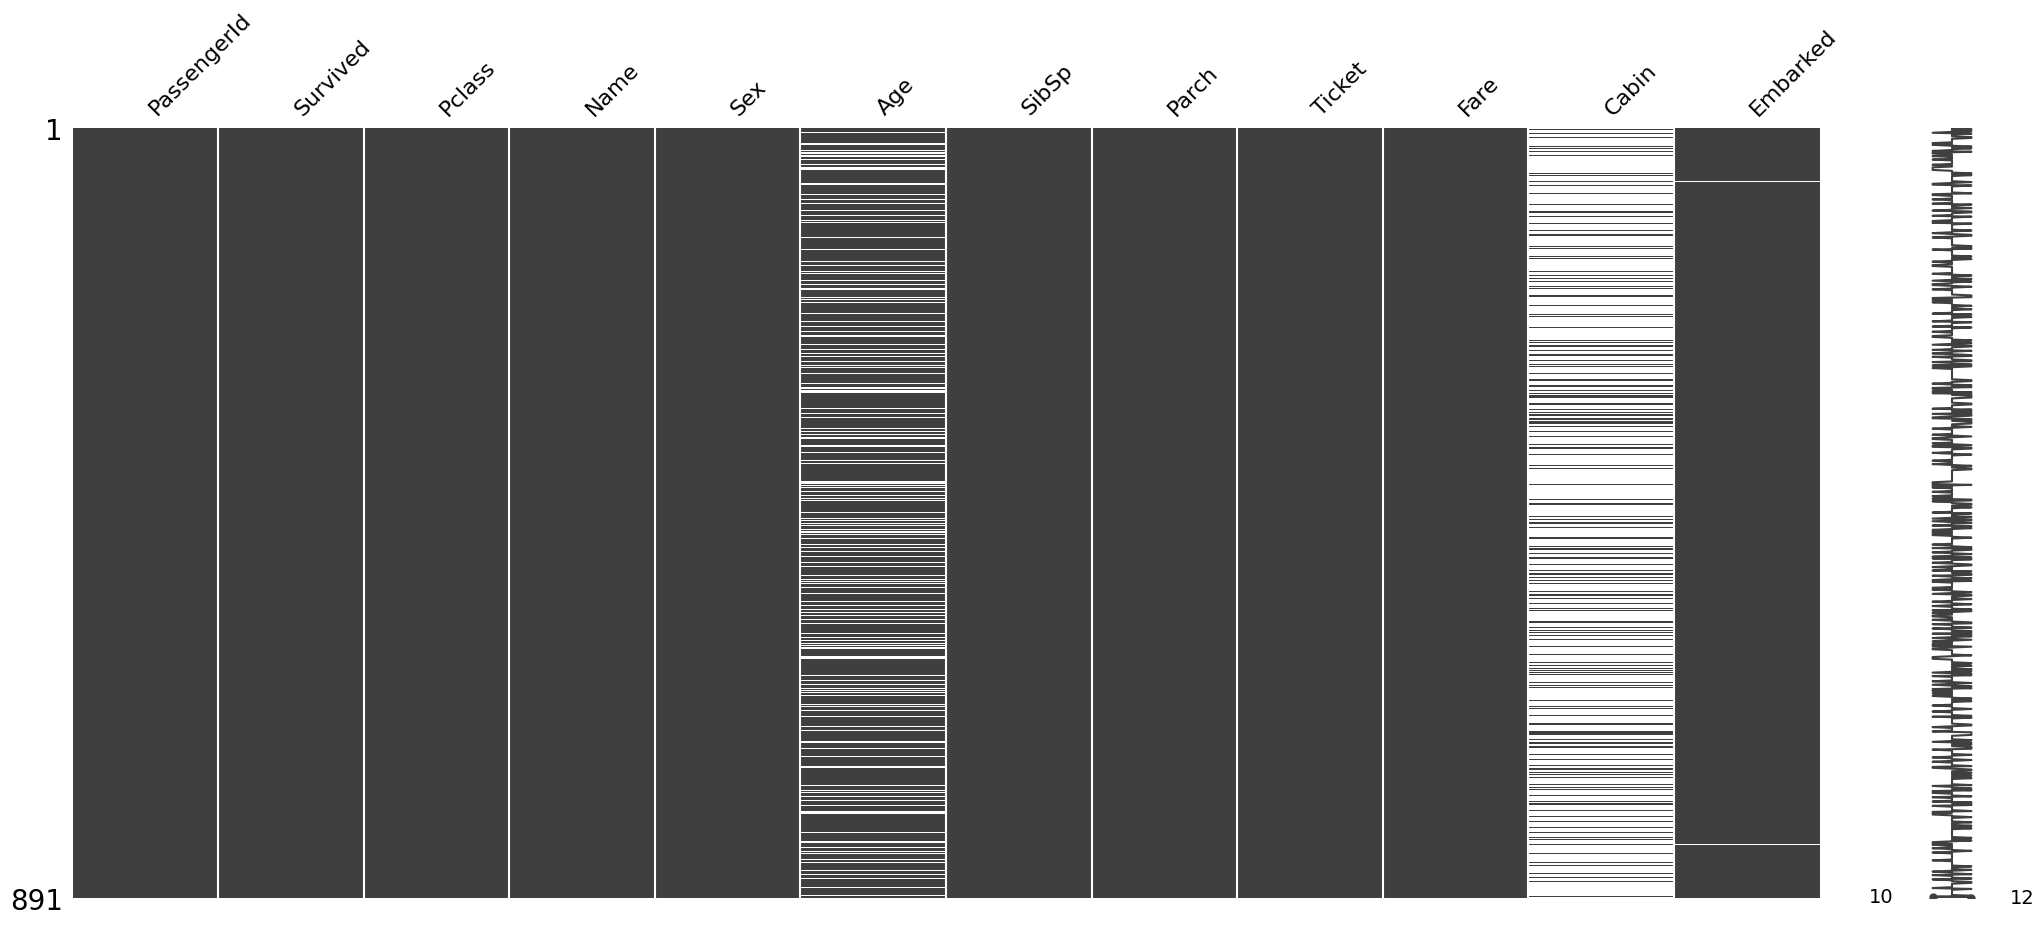

In [31]:
missing_values_train = missing_values(df_train)

Missing 19.87 % of `Age` column, which is significant but not overwhelming.

Potential solutions:
    Impute using predictive modeling. Missing may relate to specific passnger groups (e.g. ticket class or survival)

With 77.1 % mssing Cabin values, imputation may not be reliable.

Only 0.22 % mssing Embarked values, making this relatively minor. Imputation is traighforward using the most common value `mode`.

In [32]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Mean `Survived` value is 0.38, indicating an overall survival rate of ~ 38 %. We should analyze survival rate differences by groups (Pclass, Sex, Age).

Mean `Fare` is significantly higher than the median, indicating a skewed distribution. Consider log-tranforming `Fare` for analysis to reduce skewness.

Mean `Age` is 29.7, with a standard deviation of 14.5, indicatig variability in passenger ages. Youngest is 0.42 years, and the oldest is 80. Median `Age` 28 is close to the mean, suggesting relatively normal distribution.

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Column Age has 86 missing values, or 20.57%.
Column Fare has 1 missing values, or 0.24%.
Column Cabin has 327 missing values, or 78.23%.
Axes(0.125,0.11;0.698618x0.77)


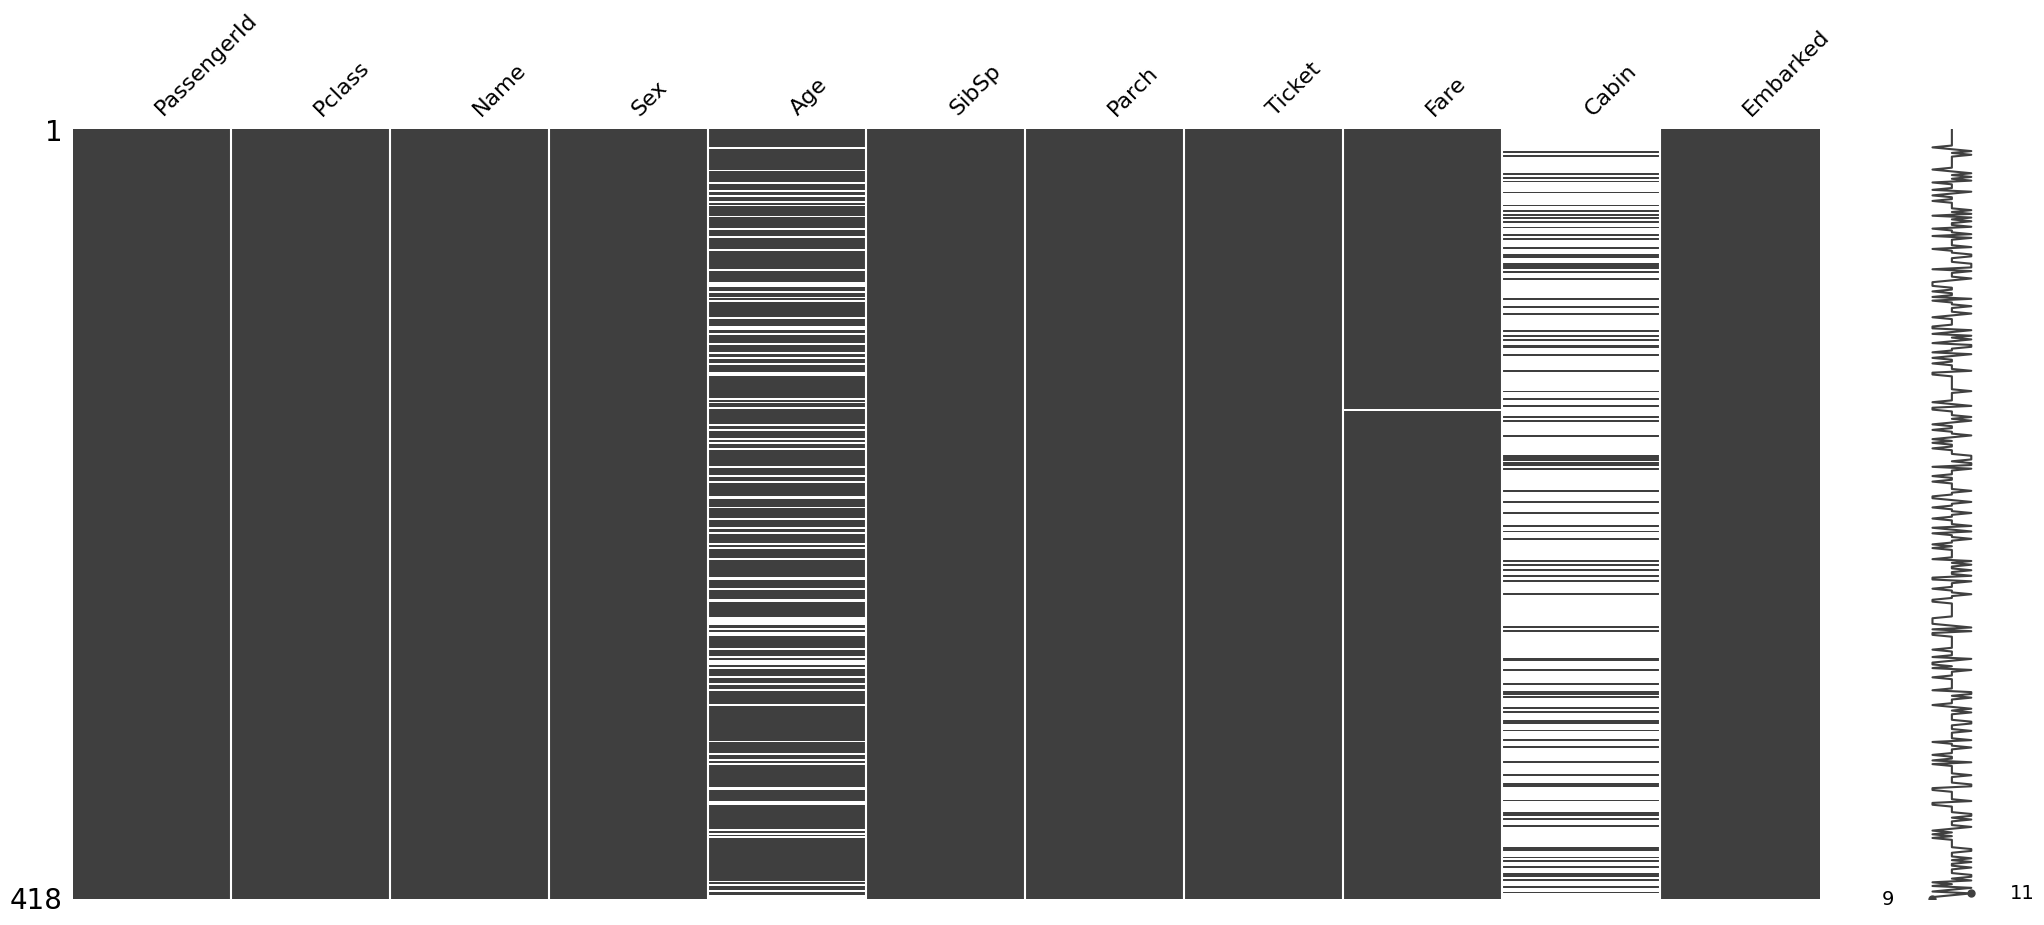

In [34]:
missing_values_test = missing_values(df_test)

In [35]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


## 4.2 Feature Analysis

A DataFrame is composed of rows and columns. The rows correspond to observations in the dataset, while the columns, often referred to as features, describe the characteristics of these observations. In our dataset, the rows represent passngers on the Titanic, and the columns are features that describe these passengers, such as their age, gender, and ticket class.

It is important to distibguish between categorical and numerical variables:
* Categorical variables consist of values that fall into one of two or more categories, typically without an inherent order.
* Numerical variables, on the other hand, have a continuous range of values. Examples from our dataset include the Age and Fare features.

### Categorical Variables

#### Sex

In [37]:
def categorical_variables_visualization(data_frame: pd.DataFrame, column_name: str, target=False, visualization=False, hue_column=False):
    """
    Visualizes and summarizes categorical variables in a DataFrame,
    with optional hue grouping.

    This function performs the following tasks:
    1. Prints the value counts for a specified categorical column.
    2. Optionally prints the mean of a target variable grouped by 
    column(s).
    3. Optionally creates a plot visualizing the relationship between
    the categorical column(s) and the target variable.
    4. Optionally includes a hue groiping for better visualization and
    analysis.

    Parameters:
    ---------------
    data_frame: pd.DataFrame
        The pandas DataFrame containing the data.

    column_name: str
        The name of the categorical column to analyze.

    target: str, optional, default=False
        The name of the target variable for grouping and calculating
        the mean.

    visualization: str, optional, default=False
        The type of plot to create. Supported types are strip,
        box, violin, etc. If False, no plot will be generated.

    hue_column: str, optinal, default=False
        The name of the column to be used for hue grouping in the 
        plot. If false, no hue grouping will be applied. The function
        will only analyze and visualize the column_name.

    Returns:
    -------------
    None
        The function prints summary statistics and may display a plot,
        but does not return any values.
    
    Raises:
    ------------
    ValueError
        If the specified column_name, hue_column, or target is not found in 
        the DataFrame.

    Exception
        Any other exception encountered during the execution will be 
        caught and printed
    """
    def value_error_message(name: str) -> str:
        return f'Column \033[94m{name}\033[0m not found in the dataframe.'
    try:
        if hue_column:
            if hue_column not in data_frame.columns:
                raise ValueError(value_error_message(hue_column))
            if column_name not in data_frame.columns:
                raise ValueError(value_error_message(column_name))
            print(f'This is the value counts for the columns \033[94m{column_name}\033[0m and \033[94m{hue_column}\033[0m :')
            print(data_frame[[column_name, hue_column]].value_counts(dropna=False))
            print('\n')
            
            if target:
                if target not in data_frame.columns:
                    raise ValueError(value_error_message(target))
                print('------------------------------------------')
                print(f'The mean of the target variable \033[94m{target}\033[0m grouped by the categorical columns \033[94m{column_name}\033[0m and \033[94m{hue_column}\033[0m :')
                print(data_frame[[column_name, hue_column, target]].groupby([column_name, hue_column], as_index=False).mean().sort_values(target, ascending=False))
                print('\n')

            if visualization:
                print('------------------------------------------')
                print(f'Creating a {visualization} plot for the \033[94m{column_name}\033[0m and \033[94m{hue_column}\033[0m columns with respect to \033[94m{target}\033[0m ...')
                sns.catplot(x=column_name, y=target, hue=hue_column, data=data_frame, kind=visualization)
                plt.ylabel(f'{target.title()} Probability')
                plt.xlabel(f'{column_name.title()}')
                plt.title(f'{target.title()} Probability by {column_name.title()} and {hue_column.title()}')
                plt.plot()
                print('\n')
            
        else:  
            if column_name not in data_frame.columns:
                raise ValueError(f'Column \033[94m{column_name}\033[0m not found in the dataframe.')
        
            print(f'This is the value counts for the column \033[94m{column_name}\033[0m :')
            print(data_frame[column_name].value_counts(dropna=False))
            print('\n')
            if target:
                if target not in data_frame.columns:
                    raise ValueError(f'Target column \033[94m{target}\033[0m not found in the dataframe.')
                
                print('------------------------------------------')
                print(f'The mean of the target variable \033[94m{target}\033[0m grouped by the categorical column \033[94m{column_name}\033[0m :')
                print(data_frame[[column_name, target]].groupby(column_name, as_index=False).mean().sort_values(target, ascending=False))
                print('\n')
            
            if visualization:
                print('------------------------------------------')
                print(f'Creating a {visualization} plot for the \033[94m{column_name}\033[0m column with respect to \033[94m{target}\033[0m ...')
                sns.catplot(x=column_name, y=target, data=data_frame, kind=visualization)
                plt.ylabel(f'{target.title()} Probability')
                plt.xlabel(f'{column_name.title()}')
                plt.title(f'{target.title()} Probability by {column_name.title()}')
                plt.plot()
                print('\n')
    
    except Exception as e:
        print(f'An error occurred: {e}')

The `Sex` column represents the gender of passengers. There are 577 male and 314 female passengers in the dataset. The distribution shows that there were more male passengers than female on board.

The average survival rate by sex is as follows: ~74% of female and ~19% of male passengers survived.

There is a clear gender disparity in survival rates, with females having a much higher chance of survival compared to males. The higher survival rate among female passengers could be attributed to the `woman and children first` policy during the evacuation of the Titanic, where woman were prioritized for lifeboat space.



This is the value counts for the column Sex :
Sex
male      577
female    314
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Sex :
      Sex  Survived
0  female  0.742038
1    male  0.188908


------------------------------------------
Creating a bar plot for the Sex column with respect to Survived ...




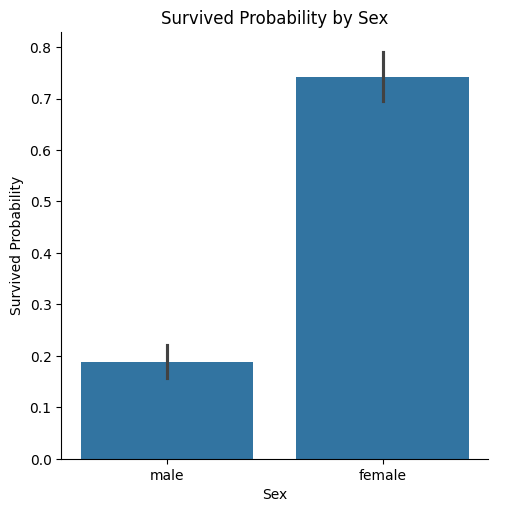

In [38]:
categorical_variables_visualization(df_train, 'Sex', target='Survived', visualization='bar')

#### Pclass

The `Pclass` variable represents the passenger class (1st, 2nd, and 3rd). There are 491 passengers in 3rd class, 216 in 1st class, and 184 in 2nd class. The distribution indicates that most passengers were in the 3rd class, followed by the 1st class, and the least in the 2nd class.

The average survival rate by class is ~63% of 1st-class passangers survived, ~47% of 2nd class, and ~24% of 3rd class. These survival rates suggest a strong relationship between passenger class and survival. First-class passengers had the highest survival rate, while third class passengers had the lowest.

This is the value counts for the column Pclass :
Pclass
3    491
1    216
2    184
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Pclass :
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


------------------------------------------
Creating a bar plot for the Pclass column with respect to Survived ...




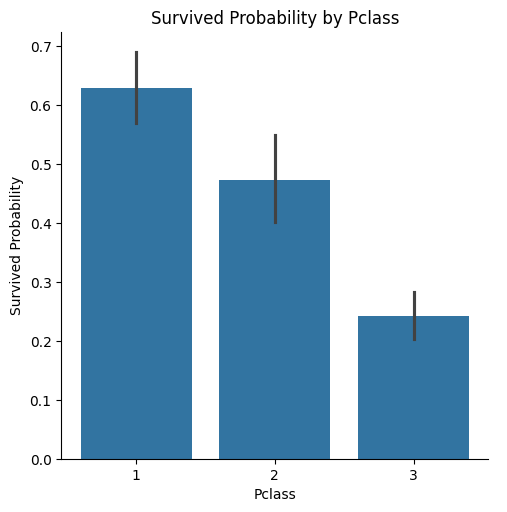

In [39]:
categorical_variables_visualization(df_train, column_name='Pclass', target='Survived', visualization='bar')

#### Pclass and Gender

The survival rate is highest for females in 1st class (97%) and females in 2nd class ~ 92% and lowest for males in 3rd class ~ 13.5%. Males had lower survival rates compared to females in all classes, with the difference being particularly stark in 1st and 2nd class, where the survival rate for males was much lower than for females. abs
The survival rate for females in 3rd class is still notably higher than for males in 3ed class (~ 13.5%).

This analysis shows that gander played a significant role in survival chances, with females being prioritized in the lifeboat evacuation process, while male passengers, especially those in lower classes, had a much lower chance of survival.

This is the value counts for the columns Pclass and Sex :
Pclass  Sex   
3       male      347
        female    144
1       male      122
2       male      108
1       female     94
2       female     76
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical columns Pclass and Sex :
   Pclass     Sex  Survived
0       1  female  0.968085
2       2  female  0.921053
4       3  female  0.500000
1       1    male  0.368852
3       2    male  0.157407
5       3    male  0.135447


------------------------------------------
Creating a bar plot for the Pclass and Sex columns with respect to Survived ...




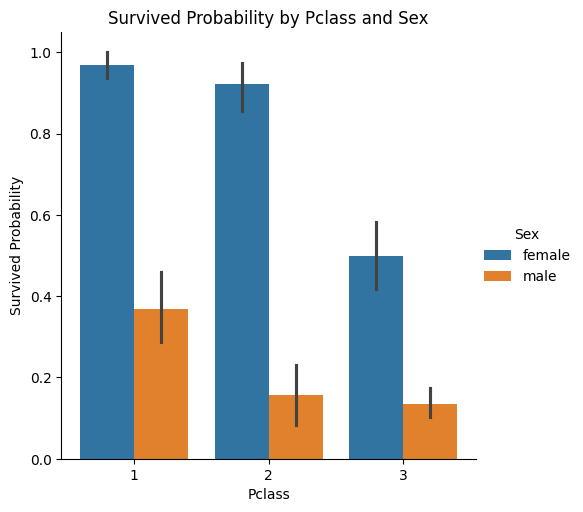

In [40]:
categorical_variables_visualization(df_train, column_name='Pclass', target='Survived', visualization='bar', hue_column='Sex')

#### Embarked

The `Embarked` column represents the port where passengers boarded the Titanic, with the following distribution:
S (Southampton): 644 passengers boarded at Southampton.
C (Cherbourg): 168 passengers boarded at Cherbourg.
Q (Queenstown): 77 passengers boarded at Queenstown.
NaN (missing values): 2 entries have missing values for the Embarked column.

Most passengers boarded in Southampton, followed by Cherbourg, and Queenstown, with a small number of missing values.

Passengers who boarded in Cherbourg had the highest survival rate, followed by those from Queenstown and Southampton.

This is the value counts for the column Embarked :
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Embarked :
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


------------------------------------------
Creating a bar plot for the Embarked column with respect to Survived ...




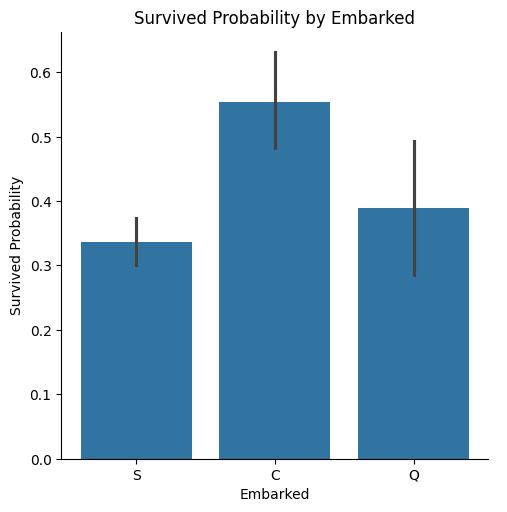

In [41]:
categorical_variables_visualization(df_train, column_name='Embarked', target='Survived', visualization='bar')

Southampton had a higher representation of 3rd class passengers, while Cherbourg and Queenstown had fewer total passengers but a larger proportion in 1st and 2nd classes.

The survival rate is highest for 1st class passengers at Cherbourg and Queenstown, followed by Southampton. The survival rate for 3rd class passengers is significatly lower, especially for those who boarded at Southampton ~ 19 %.



This is the value counts for the columns Embarked and Pclass :
Embarked  Pclass
S         3         353
          2         164
          1         127
C         1          85
Q         3          72
C         3          66
          2          17
Q         2           3
          1           2
NaN       1           2
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical columns Embarked and Pclass :
  Embarked  Pclass  Survived
0        C       1  0.694118
4        Q       2  0.666667
6        S       1  0.582677
1        C       2  0.529412
3        Q       1  0.500000
7        S       2  0.463415
2        C       3  0.378788
5        Q       3  0.375000
8        S       3  0.189802


------------------------------------------
Creating a bar plot for the Embarked and Pclass columns with respect to Survived ...




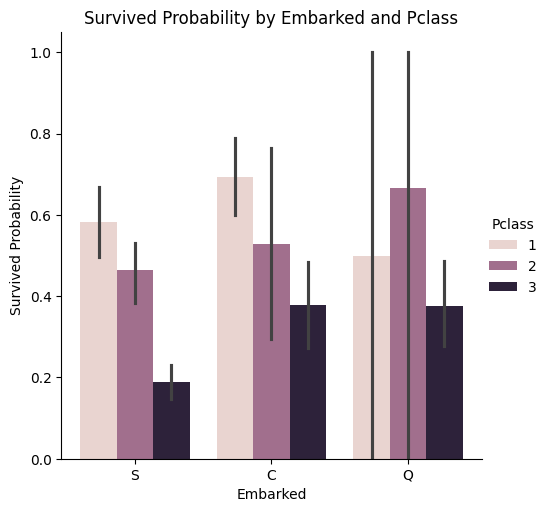

In [42]:
categorical_variables_visualization(df_train, column_name='Embarked', target='Survived', visualization='bar', hue_column='Pclass')

#### Embarked and Sex

Females from Cerbourg had the highest survival rate ~ 88 %, followed by Queenstown ~ 75 % and Southampton ~ 69%. Males had mich lower survival rates compared to females.

This is the value counts for the columns Embarked and Sex :
Embarked  Sex   
S         male      441
          female    203
C         male       95
          female     73
Q         male       41
          female     36
NaN       female      2
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical columns Embarked and Sex :
  Embarked     Sex  Survived
0        C  female  0.876712
2        Q  female  0.750000
4        S  female  0.689655
1        C    male  0.305263
5        S    male  0.174603
3        Q    male  0.073171


------------------------------------------
Creating a bar plot for the Embarked and Sex columns with respect to Survived ...




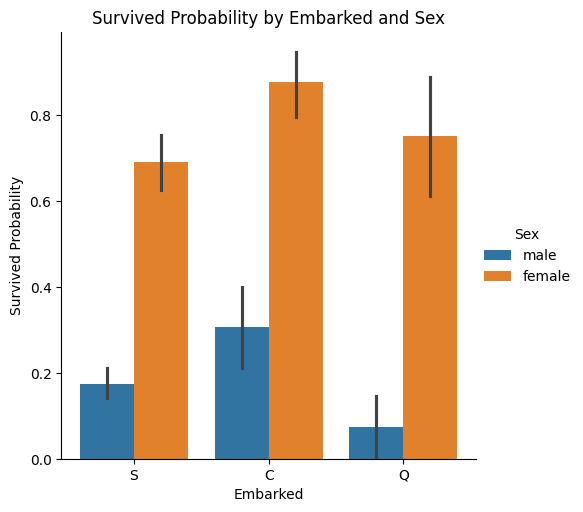

In [43]:
categorical_variables_visualization(df_train, column_name='Embarked', target='Survived', visualization='bar', hue_column='Sex')

### Numerical Variables

#### 1. Detect and Remove Outliers in numerica variables

Outliers were detected using the `IQR method`, identifying 10 indices that exhibited extreme values across multiple features. These outliers may distort statistical metrics and model performance, so their impact should be evaluated through visualization and domain-specific analysis. Based on the findings, they can be corrected, removed, or retained if they provide critical insights.

In [44]:
def delete_outliers(data_frame: pd.DataFrame, n: int, features: list) -> list:
    """
    Detect and Identifies outliers in the specified features of a 
    DataFrame.

    This function iterates through a list of numerical features and detects
    outliers in each feature based on the IQR method. An outlier is defined
    as a value below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    If an index appears as an outlier in more than N features, it is added to the 
    final list of multiple outliers.

    Parameters:
    ---------------
    data_frame: pd.DataFrame
        The DataFrame containing the data to analyze.

    n: int
        The minimum number of features in which a data point must be an outlier
        to be considered a multiple outlier.

    features: list
        A list of column names (features) to analyze for outliers.
        Those should be numerical columns.

    Returns:
    -------------
    list
        A list of indices corresponding to data points that are outliers
        in more than n features.

    Raises:
    ------------
    TypeError
        If data_frame is not a pandas DataFrame, or if features is not a list.

    ValueError
        If n is negative, or if a feature in the features list is not in
        the DataFrame.
    """
    if not isinstance(data_frame, pd.DataFrame):
        raise TypeError("`data_frame` must be a pandas DataFrame.")
    if not isinstance(features, list):
        raise TypeError("`features` must be a list of column names.")
    if not isinstance(n, int) or n < 0:
        raise ValueError("`n` must be a non-negative integer.")
        
    outliers = []
    for feature in features:
        Q1 = np.percentile(data_frame[feature], 25)
        Q3 = np.percentile(data_frame[feature], 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR

        outlier_list = data_frame[(data_frame[feature] < lower) | (data_frame[feature] > upper)].index
        outliers.extend(outlier_list)
    outliers = Counter(outliers)
    multiple_outliers = list(key for key, value in outliers.items() if value > n)
    return multiple_outliers



In [45]:
outliers = delete_outliers(df_train, 2, [x for x in df_train.columns if df_train[x].dtype != 'object'])
print(outliers)

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [46]:
print(f'Rows before: {len(df_train)}')
df_train = df_train.drop(outliers, axis=0).reset_index(drop=True)
print(f'Rows after: {len(df_train)}')

Rows before: 891
Rows after: 881


#### 2. Num variable correlation with survival

In [47]:
df_train[[x for x in df_train.columns if df_train[x].dtype != 'object' and x != 'PassengerId']].corr().round(2)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.00,-0.33,-0.08,0.00,0.09,0.26
Pclass,-0.33,1.00,-0.37,0.07,0.02,-0.56
Age,-0.08,-0.37,1.00,-0.31,-0.19,0.11
SibSp,0.00,0.07,-0.31,1.00,0.38,0.11
Parch,0.09,0.02,-0.19,0.38,1.00,0.18
Fare,0.26,-0.56,0.11,0.11,0.18,1.00


* `Fare` and `Pclass` show a strong negative correlation - 0.56, meaning that as the passenger class increases, the fare generally decreases. This is expected, as 1st class tickets tend to be more expensive.

* `SibSp` and `Parch` have a moderate positive correlation 0.38, indicating that passengers traveling with more family members tend to have higher family group counts.

* `Survived` has weak correlations with most features except for `Fare` 0.26, suggesting that the survival rate is somewhat positively correlated with the fare, meaning wealthier passengers had higher chances of survival.

* `Age` has weak correlations with other variables, although it negatively correlates with `Pclass` - 0.37, suggesting that older passengers were more likely to be in lower classes.

* `SibSp` and `Parch` have weak correlations with the `Survival` rate, with no strong indication that being with family significantly influenced survival.


##### 3. Numerical Variable

#### SibSp

Passengers with 1 sibling/spouse had the highest survival rate of ~ 53.5 %, followed by passengers with 2 siblings/spouses.

Survival rates dropped significantly for passengers with larger families. Those with 4 had a survival rate of ~ 17 %, 3 siblings/spouses ~ 15 % and 5 sublings - 0 %.

There is a positive association between having 1 or 2 family members and a higher chance of survival, which might indicate a potential family-oriented dynamic during the rescue.

This is the value counts for the column SibSp :
SibSp
0    608
1    209
2     28
4     18
3     13
5      5
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column SibSp :
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
4      4  0.166667
3      3  0.153846
5      5  0.000000


------------------------------------------
Creating a bar plot for the SibSp column with respect to Survived ...




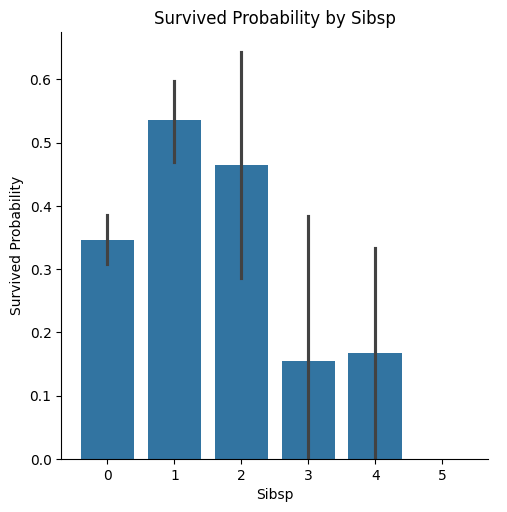

In [48]:
categorical_variables_visualization(df_train, column_name='SibSp', target='Survived', visualization='bar')

#### Parch

Like with `SibSp`, having 1 or 2 family members aboard appears to be associated with a higher chance of survival, possibly due to better chances of securing space on lifeboats or mutual support in the chaotic environment.

The survival rate significantly drops for those with larger families, especially for passengers with 4 or more parents/children, which might be due to the practical limitations of rescuing large groups.

Survival rate for those with no family is much lower, suggesting that family members palyed a prtective role during the evacuation.

This is the value counts for the column Parch :
Parch
0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Parch :
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.542857
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


------------------------------------------
Creating a bar plot for the Parch column with respect to Survived ...




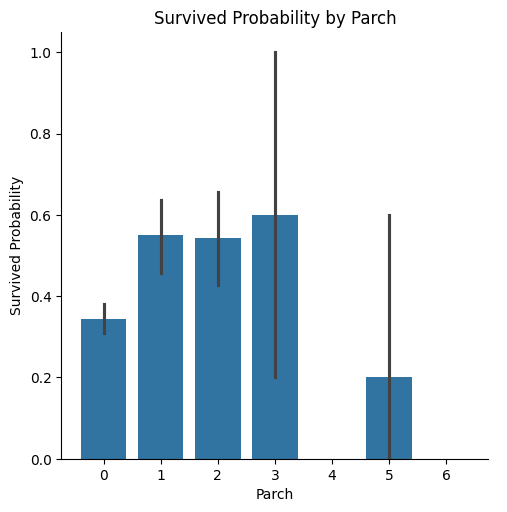

In [49]:
categorical_variables_visualization(df_train, column_name='Parch', target='Survived', visualization='bar')

#### Age

The skewness of a variable, provides valuable insights into the distribution of that variable. A skewness value of 0.38 indicates that the distribution of ages in our training dataset is slightly positively skewed.

In [50]:
def kdeplot_visualization(data_frame: pd.DataFrame, column_name: str, distribution=False):
    """
    Generates a Kernel Density Estimation (KDE) plot for a given column
    in the DataFrame. Optionally, it can also group the KDE plots by 
    another column specified in the distribution parameter.

    Parameters:
    --------------
    data_frame: pd.DataFrame
        The input DataFrame containing the data.

    column_name: str
        The name of the column for which the KDE plot will be generated.

    distribution: str, optional, default = False
        An optional column name used to group the KDE plots. If provided,
        separate KDE plots will be generated for each unique value
        in this column.

    Returns:
    --------------
    None
        Displays the KDE plot.

    Raises:
    --------------
    ValueError
        If either column_name or distribution (if provided) is not found
        in the DataFrame columns.
    """
    if column_name not in data_frame.columns:
        raise ValueError(f'Column {column_name} not found in the DataFrame.')

    if distribution:
        if distribution not in data_frame.columns:
            raise ValueError(f'Column {distribution} not found in the DataFrame.')
        for unique_value in data_frame[distribution].unique():
            sns.kdeplot(data_frame[column_name][data_frame[distribution] == unique_value], label=f'{unique_value}')
        plt.xlabel(column_name)
        plt.legend()
        plt.title(f'Passenger {column_name.title()} Distribution by {distribution.title()}')
        plt.show()
    else:
        sns.kdeplot(data_frame[column_name], label=f'Skewness: {data_frame[column_name].skew().round(2)}')
        plt.legend(loc='best')
        plt.title(f'Passenger {column_name.title()} Distribution.')
        plt.show()

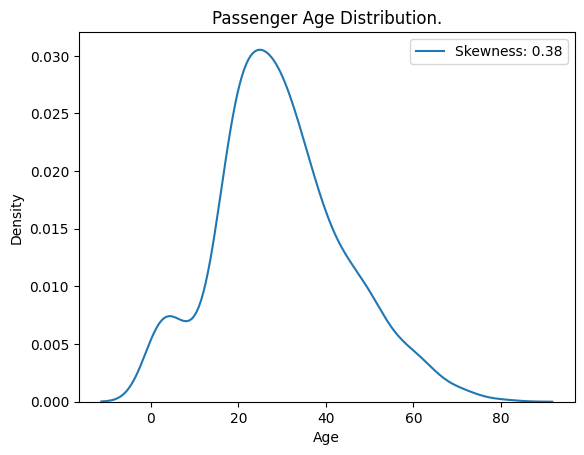

In [51]:
kdeplot_visualization(df_train, 'Age')

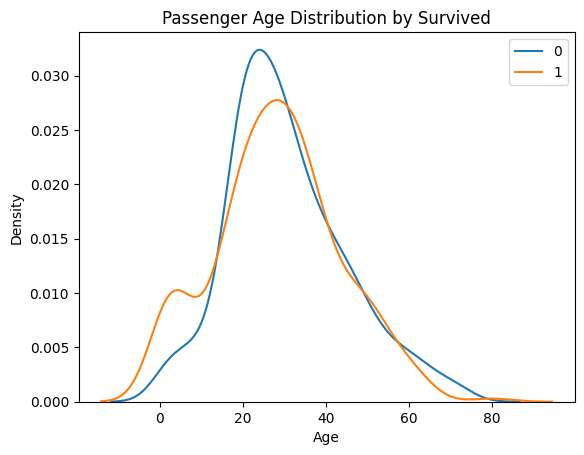

In [52]:
kdeplot_visualization(df_train, 'Age', 'Survived')

In [53]:
df_train['Age'].describe()

count    711.000000
mean      29.731603
std       14.547835
min        0.420000
25%       20.250000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [54]:
def create_age_categories(data_frame: pd.DataFrame):
    bins = [0, 20, 28, 38, 80]
    labels = ['0-19', '20-27', '28-37', '38-80']

    data_frame['Age Category'] = pd.cut(data_frame['Age'], bins=bins, labels=labels, right=False)

This is the value counts for the column Age Category :
Age Category
28-37    189
38-80    187
20-27    171
NaN      171
0-19     163
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Age Category :
  Age Category  Survived
0         0-19  0.484663
2        28-37  0.412698
3        38-80  0.374332
1        20-27  0.350877


------------------------------------------
Creating a bar plot for the Age Category column with respect to Survived ...




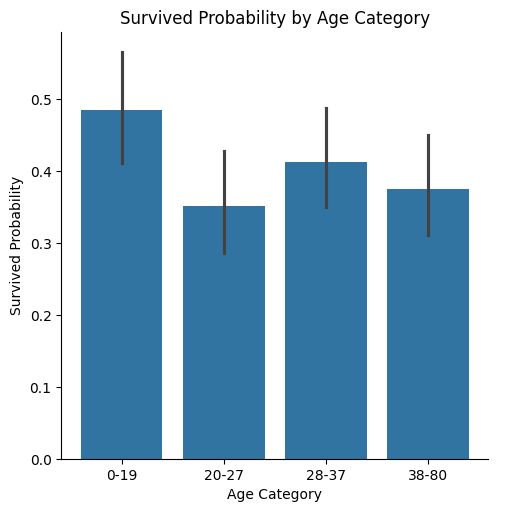

In [55]:
create_age_categories(df_train)
categorical_variables_visualization(df_train, column_name='Age Category', target='Survived', visualization='bar')

The Age column was categorized into four group. Analysis revealed that younger passengers 0-19 had the highest survival rate ~ 48.5 %, while older passengers had the lowest ~ 37.5 %. This age-based segmantation highlights a potential relationship between age groups and survival likelihood.

Next step is to drop the Age Category column

In [56]:
df_train = df_train.drop(['Age Category'], axis=1)
df_train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


#### Fare


A skewness value of 5.06 is well above the typical threshold for moderate skewness (usually considered around 1 to 2). This confirms that the distribution of fares is heavily skewed to the right.
Most of the data points are clustered towards the lower end of the fare scale, with a long tail extending to the right, representing a few very high fares.


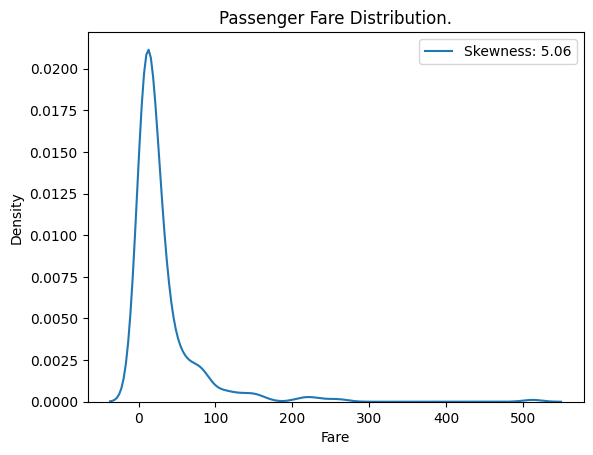

In [57]:
kdeplot_visualization(df_train, 'Fare')

# 5. Data Processing

## 5.1 Drop and Fill Missing Values

Ticket - often unstructered and may not directly affect survival. Can be dropped.

Cabin - many missing values. Can be dropped.

In [58]:
df_train = df_train.drop(['Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin'], axis=1)

Column Age has 170 missing values, or 19.3%.
Column Embarked has 2 missing values, or 0.23%.
Axes(0.125,0.11;0.698618x0.77)


{'Age': 170, 'Embarked': 2}

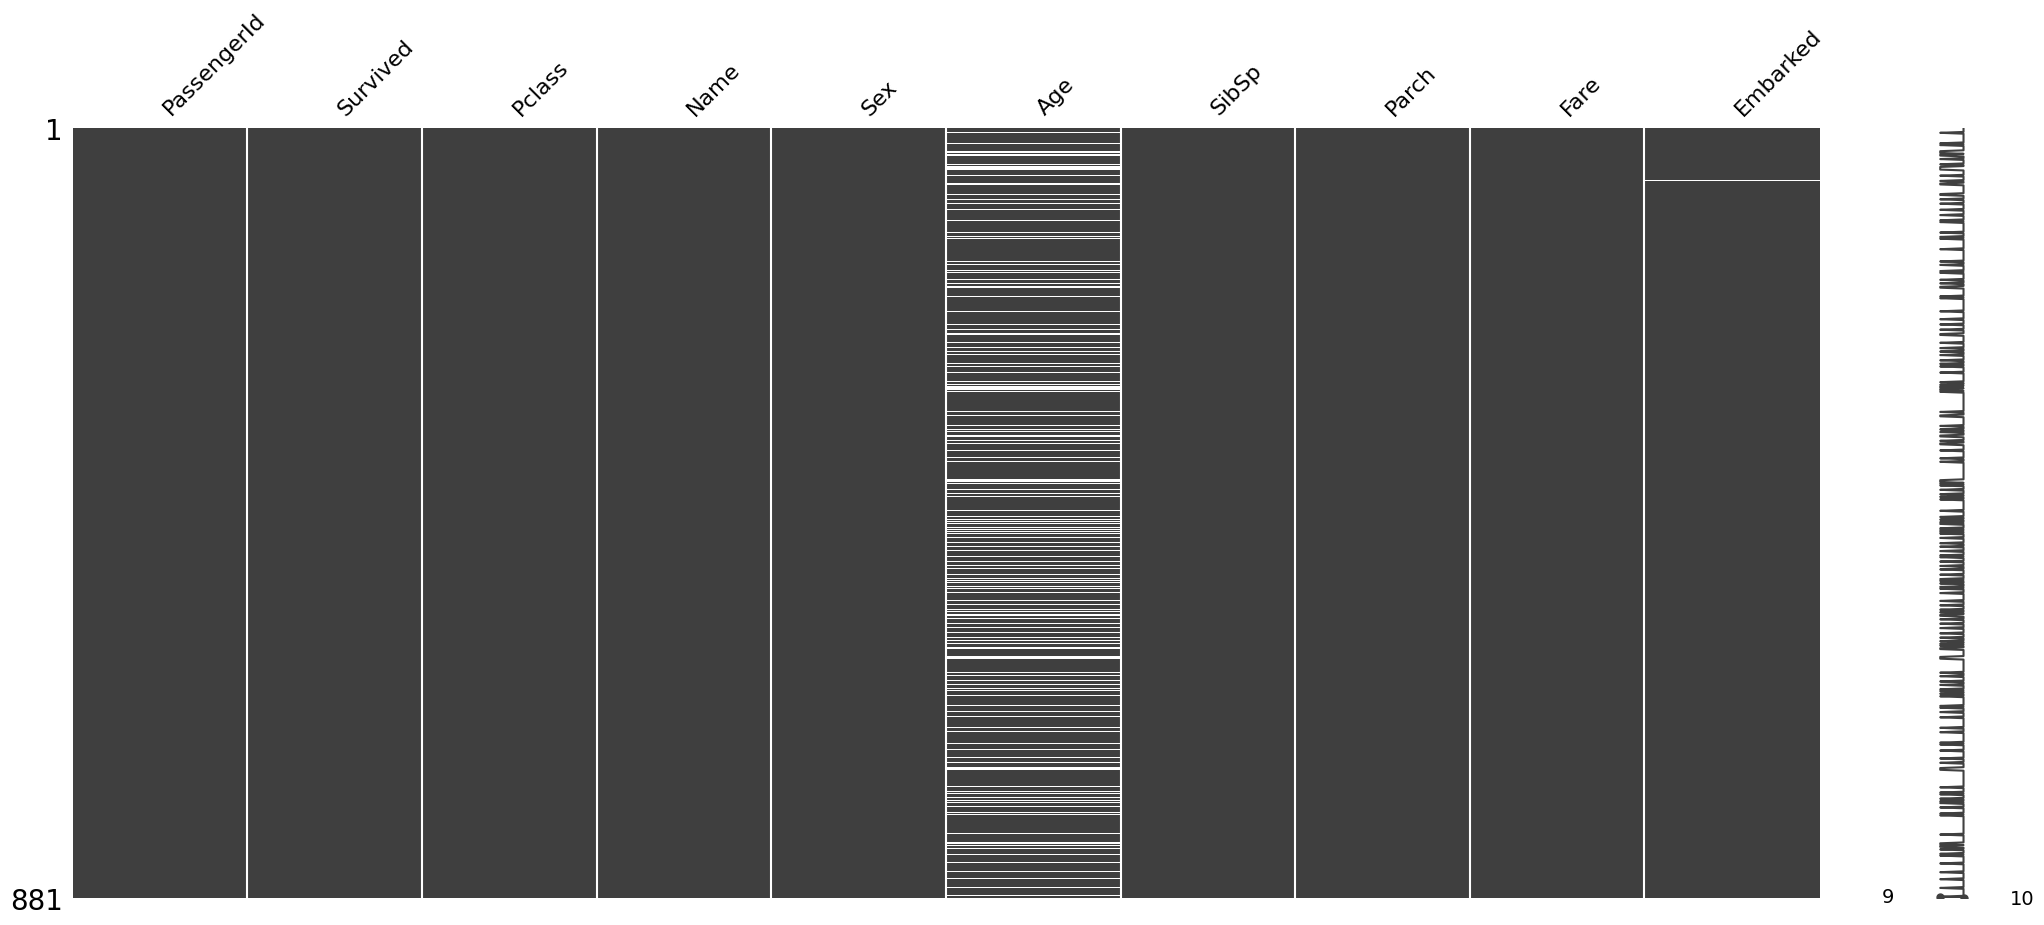

In [59]:
missing_values(df_train)

Column Age has 86 missing values, or 20.57%.
Column Fare has 1 missing values, or 0.24%.
Axes(0.125,0.11;0.698618x0.77)


{'Age': 86, 'Fare': 1}

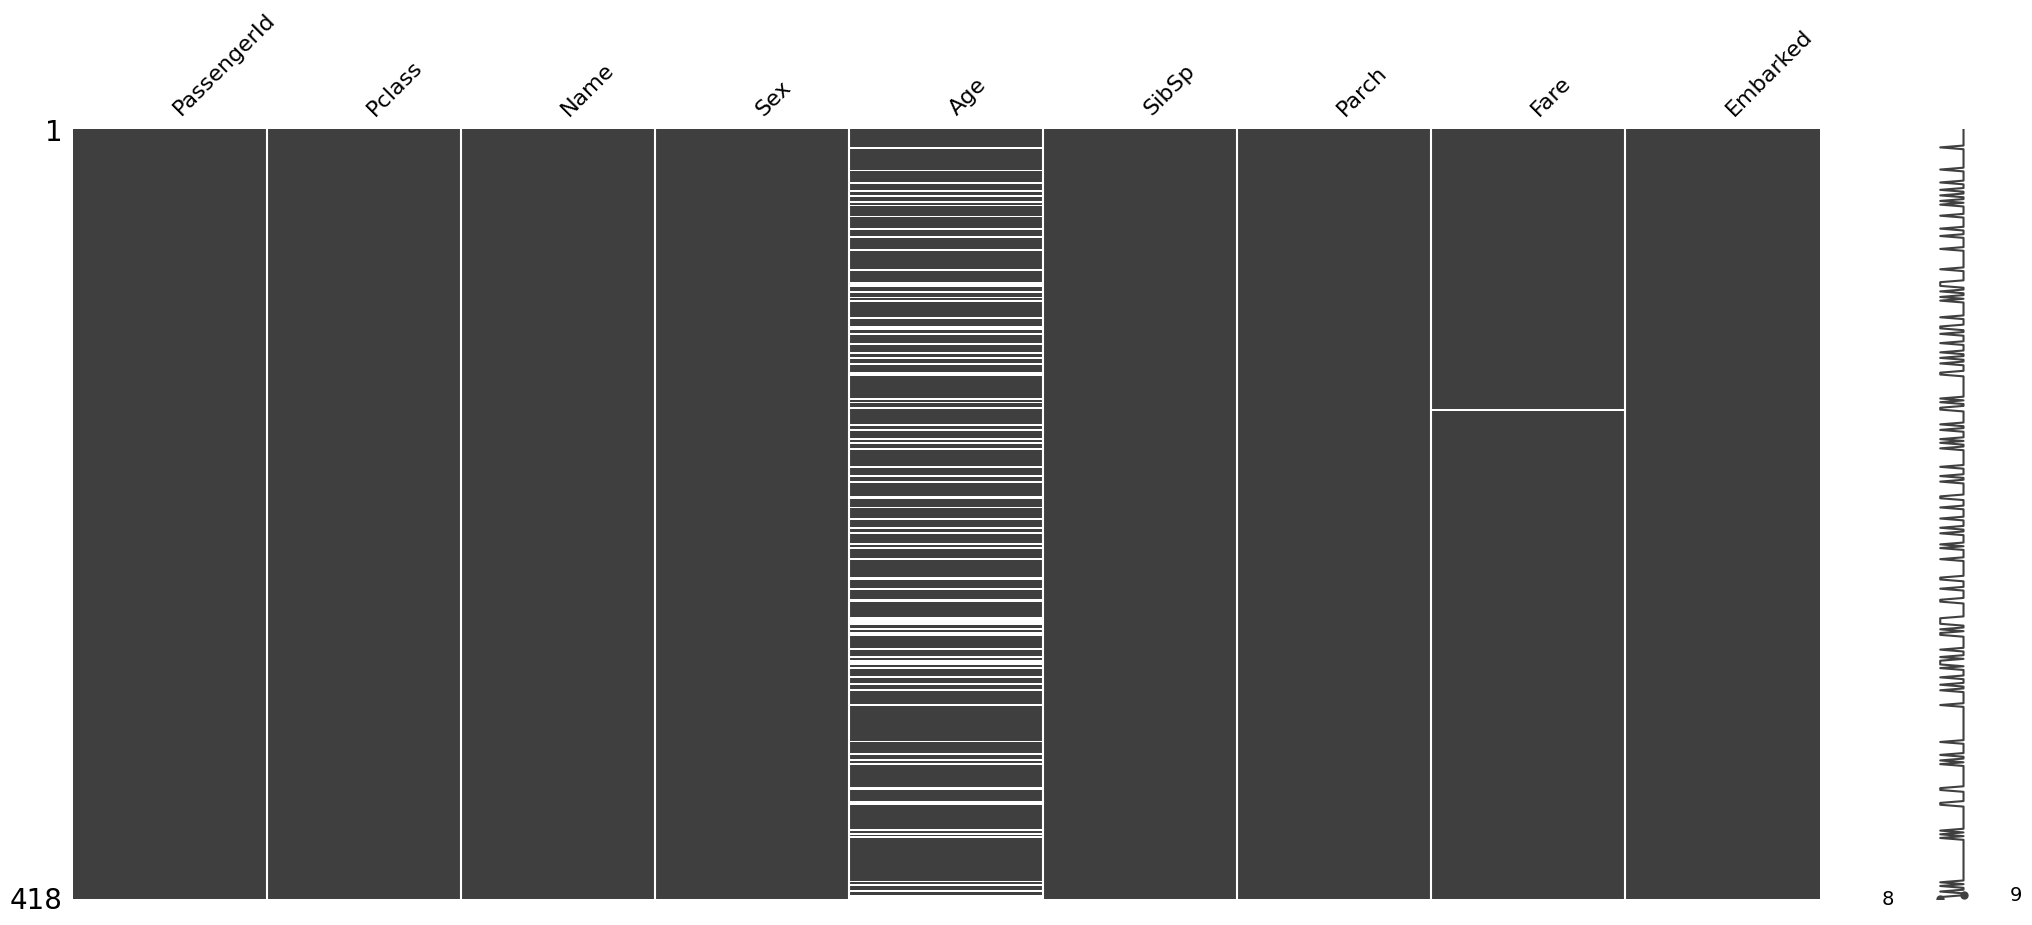

In [60]:
missing_values(df_test)

To ensure consistent preprocessing and feature engineering across both datasets, we combine the train and test datasets into a single DataFrame. This approach allows us to handle missing values, scale features, and create new ones uniformly before splitting them back into separate datasets for modeling. Care is taken to ensure that the target variable is only available in the train dataset.

In [61]:
df_combine = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df_combine.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S


In [62]:
df_combine.shape

(1299, 10)

Column Survived has 418 missing values, or 32.18%.
Column Age has 256 missing values, or 19.71%.
Column Fare has 1 missing values, or 0.08%.
Column Embarked has 2 missing values, or 0.15%.
Axes(0.125,0.11;0.698618x0.77)


{'Survived': 418, 'Age': 256, 'Fare': 1, 'Embarked': 2}

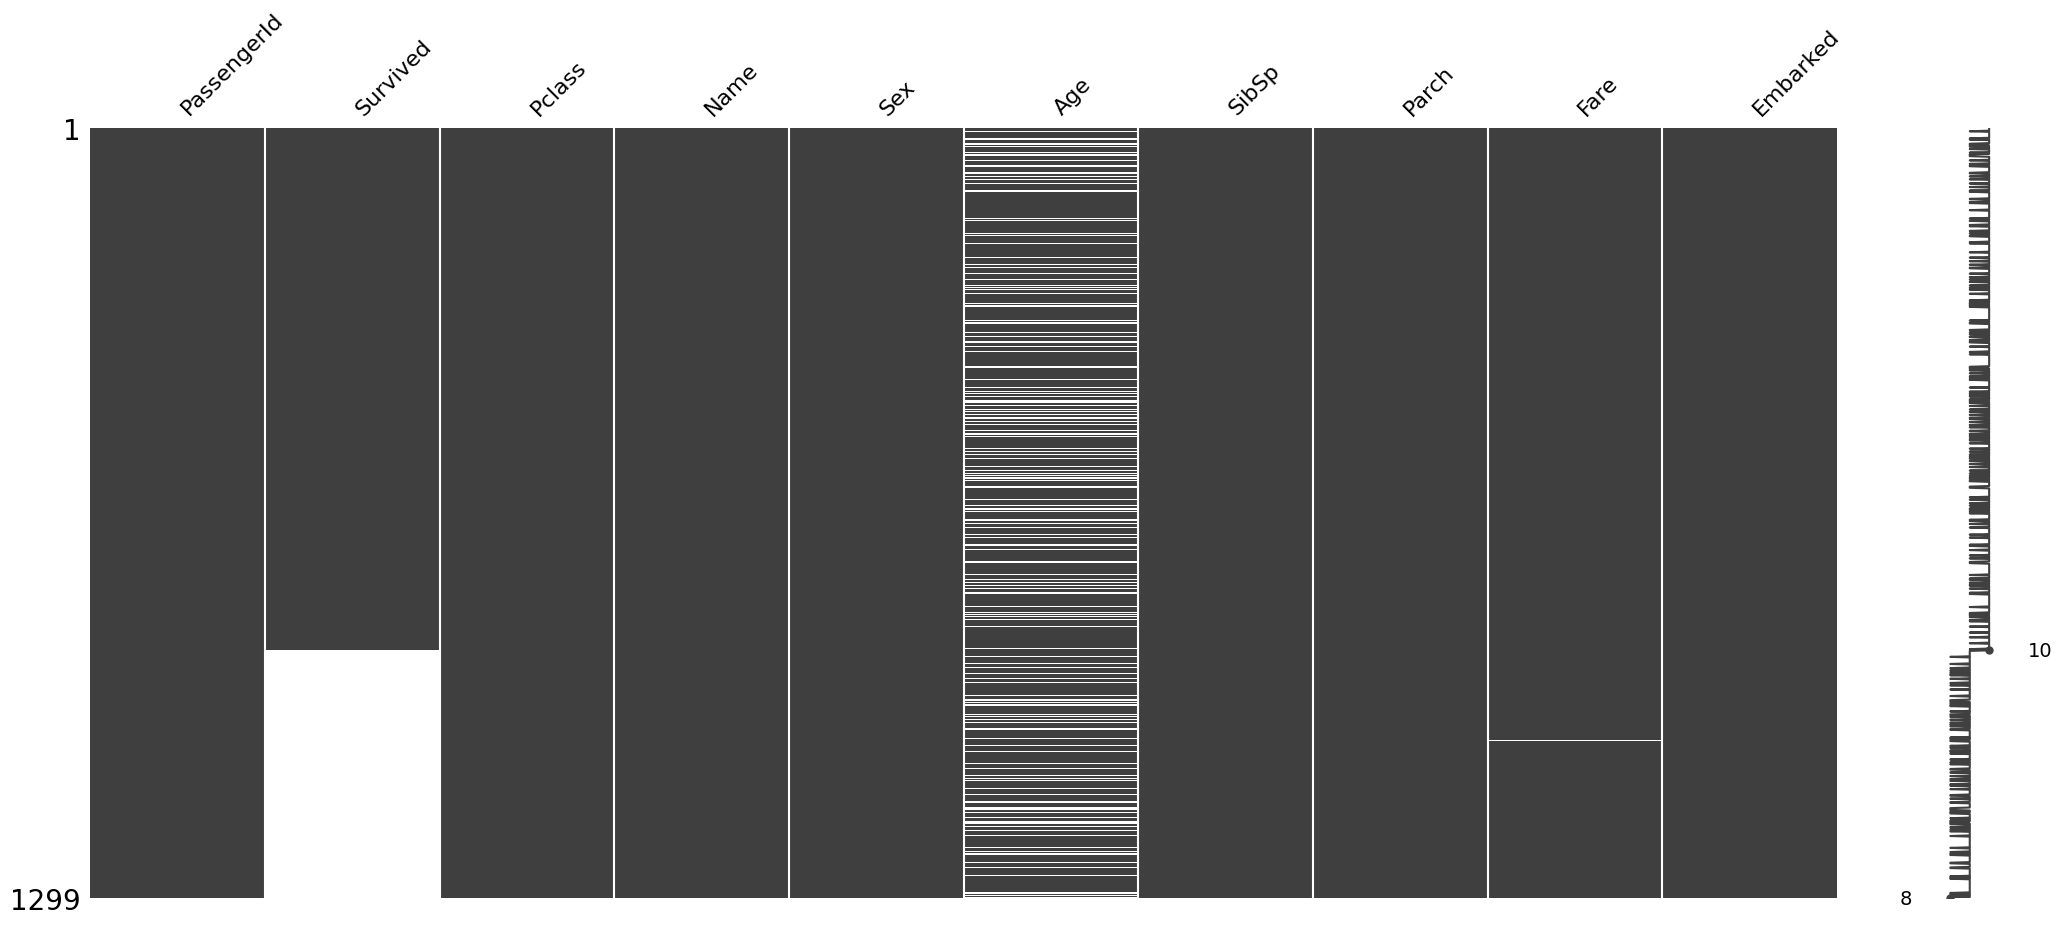

In [63]:
missing_values(df_combine)

### Embarked

The column had 2 missingvalues, accounting for 0.15 % of the data. Since these missing entries lacked specific context, we filled them using the mode of the column, which represents the most frequent embarkation port. This ensures consistency and minimizes bias while preserving the distribution of the data.

In [64]:
df_combine['Embarked'].fillna(df_combine['Embarked'].dropna().mode()[0], inplace=True)

### Fare

The column had 1 missing value, accounting for 0.08 % of the data. To address this, we imputed the missing value using the median of the column. The median is chosen to prevent outliers from skewing the imputed value, ensuring a robust and consistent approach to handling this missing data point.

In [65]:
df_combine['Fare'].fillna(df_combine['Fare'].dropna().median(), inplace=True)

Column Survived has 418 missing values, or 32.18%.
Column Age has 256 missing values, or 19.71%.
Axes(0.125,0.11;0.698618x0.77)


{'Survived': 418, 'Age': 256}

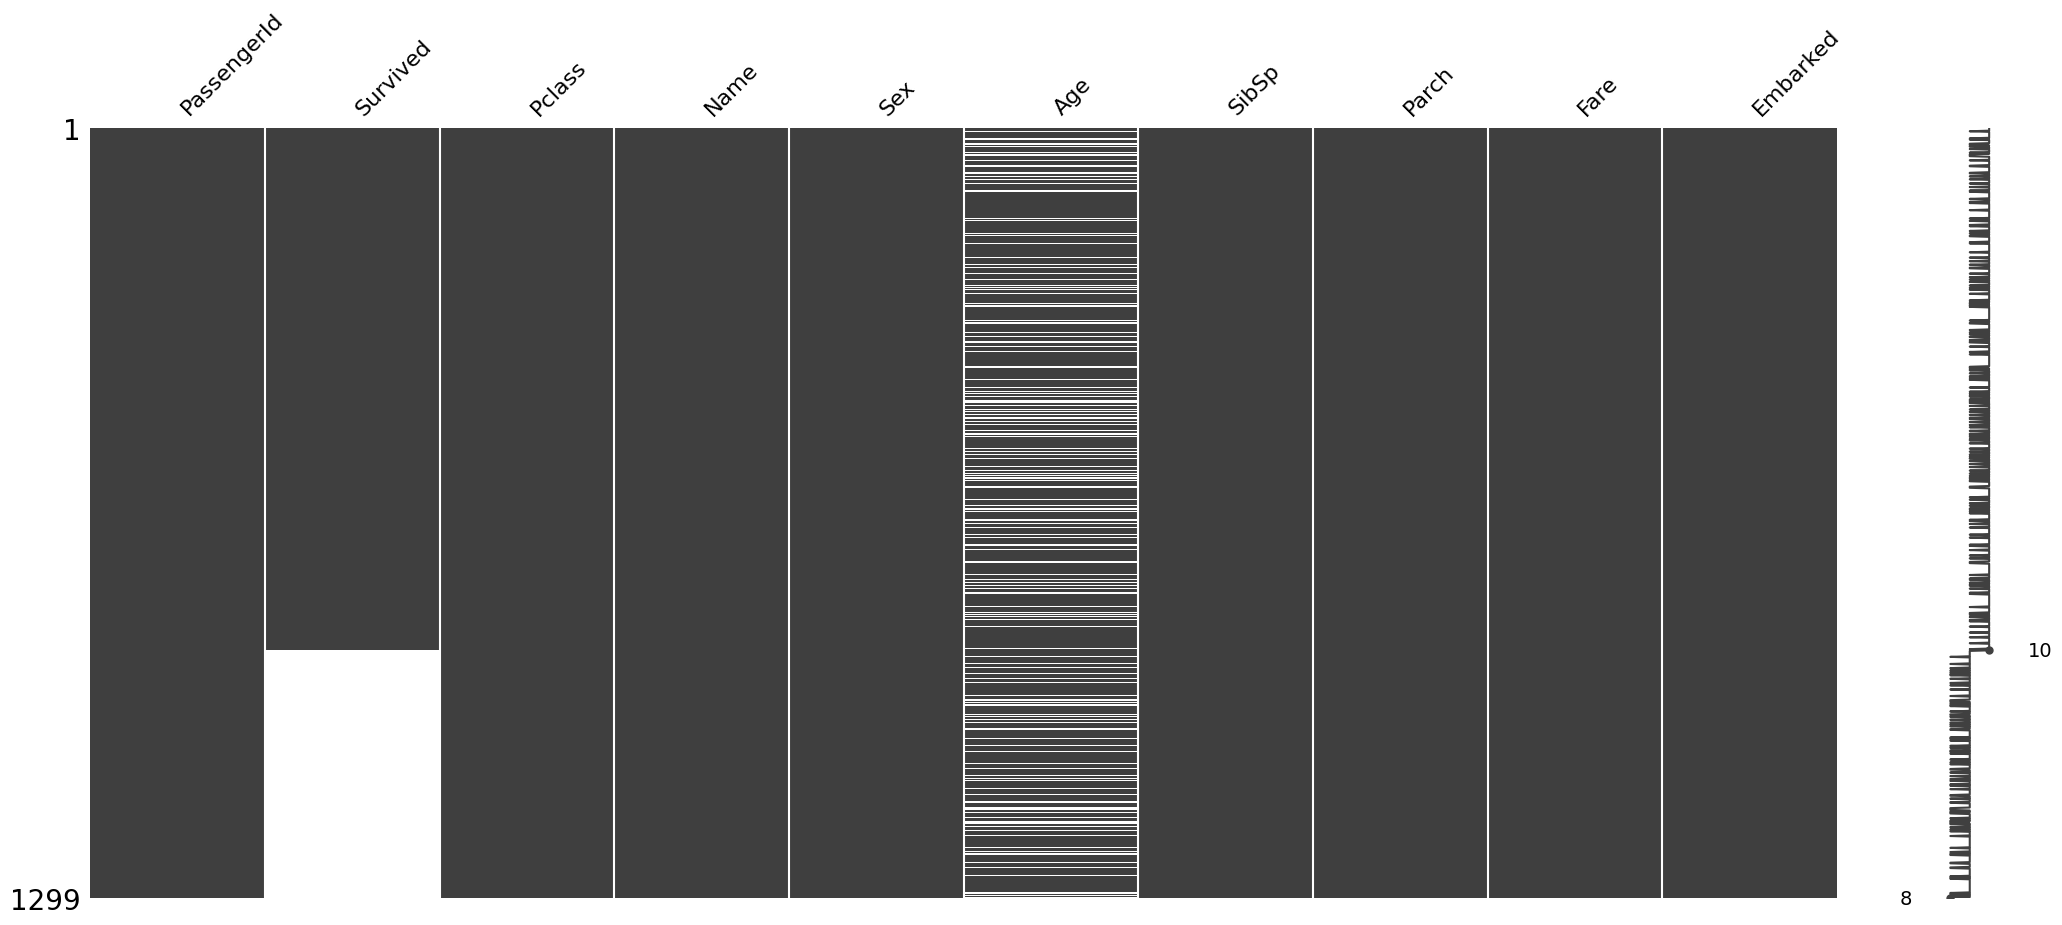

In [66]:
missing_values(df_combine)

### Encoding Sex Column

The Sex column, which contains categorical values (Male and Female), was encoded into numerical format for model compatibility. We assigned 0 for male and 1 for female, reflecting the binary nature of the data. This transformation ensures that machine learning algorithms can interpret and utlize this feature effectively.

In [67]:
df_combine['Sex'] = df_combine['Sex'].map({'male': 0, 'female': 1})

### Age

We calculated the correlation matrix for numerical columns in the dataset, excluding some columns. This analysis helps identify relationships between features, guiding feature and engineering.

In [68]:
df_combine[[x for x in df_combine.columns if df_combine[x].dtype != 'object' and x not in ['PassengerId', 'Survived', 'Fare']]].corr()

,Pclass,Sex,Age,SibSp,Parch
Pclass,1.000000,-0.124138,-0.411777,0.044041,0.016823
Sex,-0.124138,1.000000,-0.063244,0.119559,0.212624
Age,-0.411777,-0.063244,1.000000,-0.242127,-0.148784
SibSp,0.044041,0.119559,-0.242127,1.000000,0.350474
Parch,0.016823,0.212624,-0.148784,0.350474,1.000000


Based on the correlation matrix, the Age column is moderately correlated with Pclass and weakly correlated with SibSp and Parch. Using this information, the best approach for filling missing values in the Age column would be `predictive imputation` using a regression model or decision trees.

We will use features with the highest correlation with Age for prediction: Pclass, Sex, SibSp, and Parch.

In [69]:
predictors = ['Pclass', 'Sex', 'SibSp', 'Parch']
known_age = df_combine[df_combine['Age'].notnull()]
unknown_age = df_combine[df_combine['Age'].isnull()]

X_train = known_age[predictors]
Y_train = known_age['Age']
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, Y_train)

X_missing = unknown_age[predictors]
predicted_ages = model.predict(X_missing)

df_combine.loc[df_combine['Age'].isnull(), 'Age'] = predicted_ages

Column Survived has 418 missing values, or 32.18%.
Axes(0.125,0.11;0.698618x0.77)


{'Survived': 418}

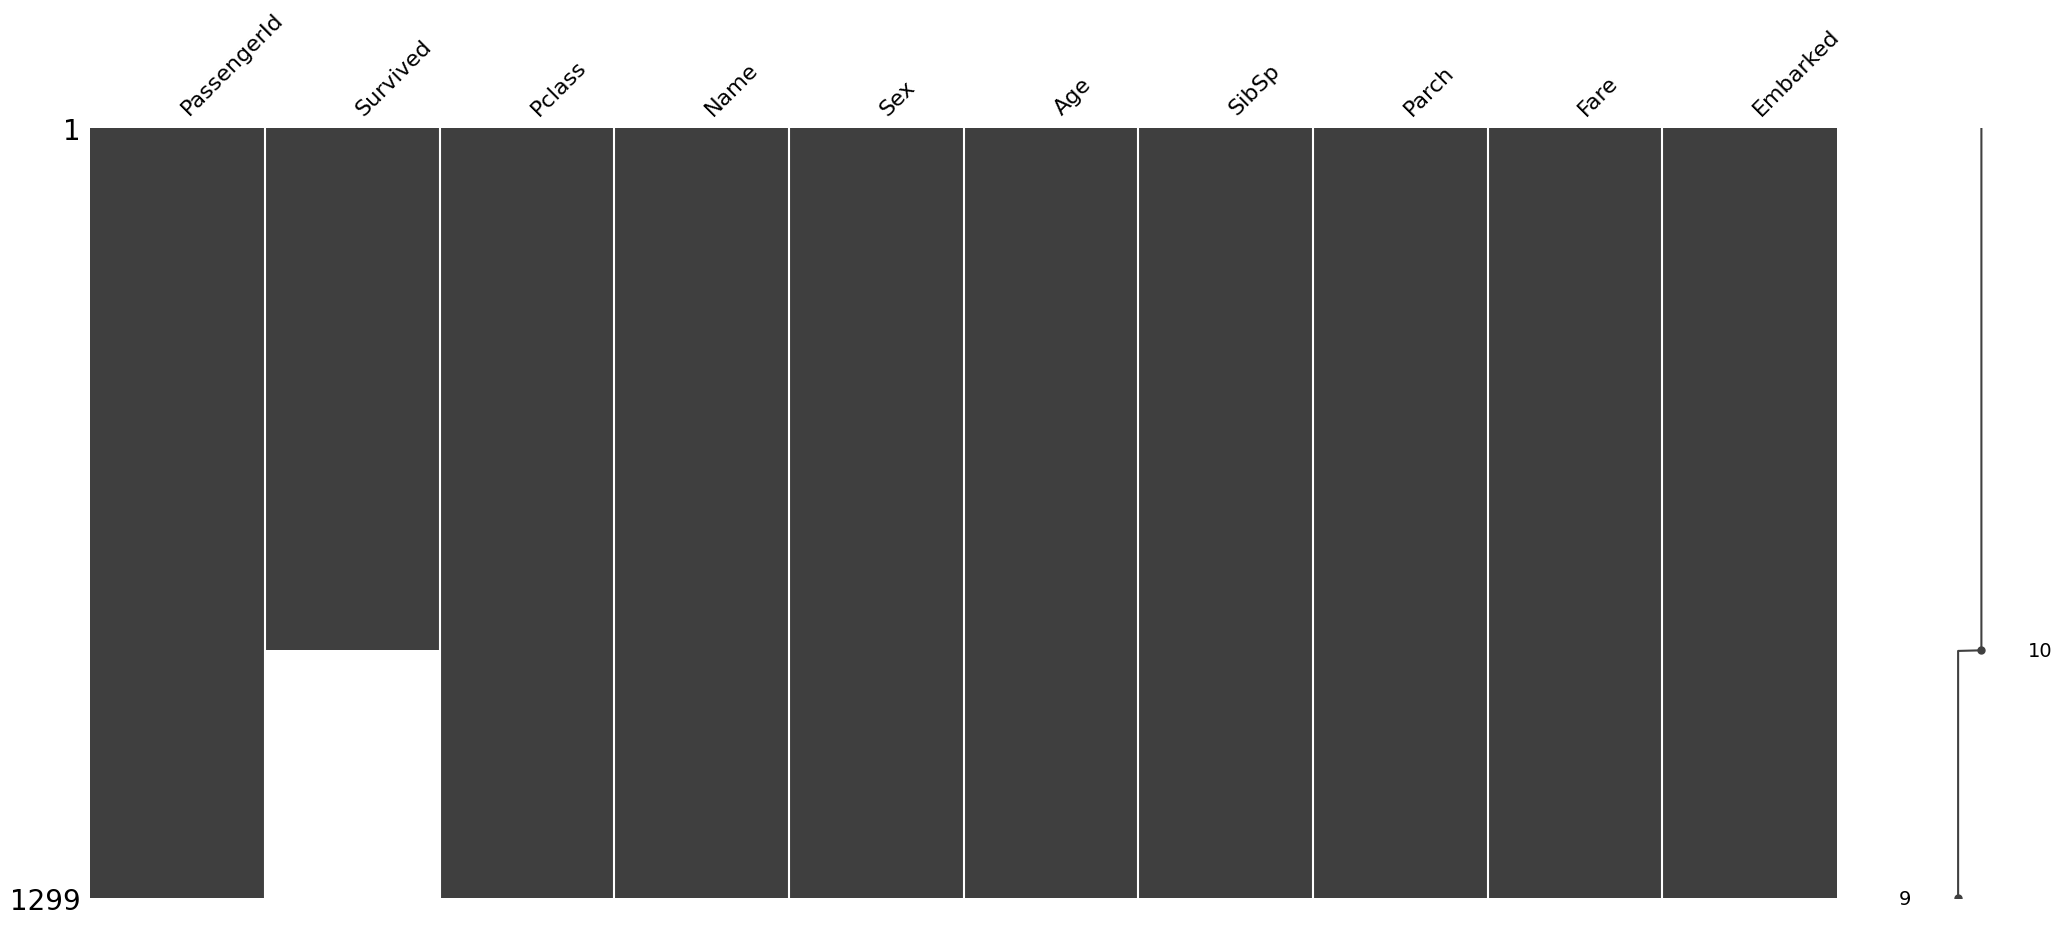

In [70]:
missing_values(df_combine)

## 5.2 Data Transformation

We already mentioned that the Fare distribution exhibits significant skewness, with a skewness value of 5.06. This indicates a heavily right-skewed distribution, where most data points are concentrated at the lower end, and a long tail extends toward higher fares. To address this issue and normalize the distribution, we will apply a log transformation to the Fare column. This transformation reduces the impact of extreme values, making the data more suitable for analysis and improving the performance of machine learning models.

In [71]:
df_combine['Fare'].skew()

4.511862011583735

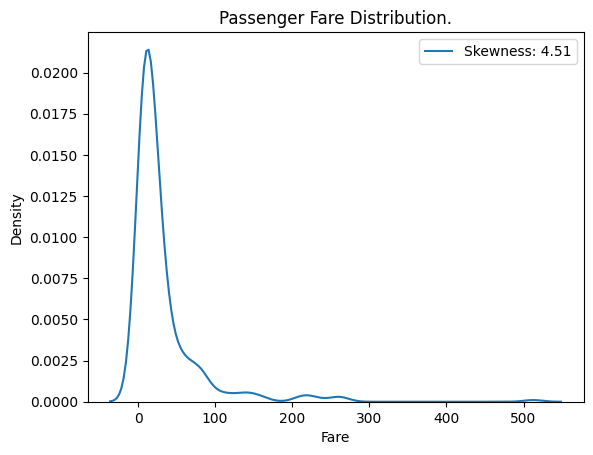

In [72]:
kdeplot_visualization(df_combine, 'Fare')

In [73]:
df_combine['Fare'] = df_combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

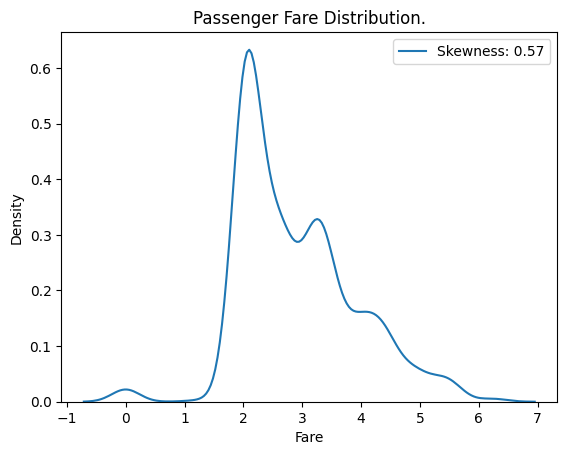

In [74]:
kdeplot_visualization(df_combine, 'Fare')

## 5.3 Features

It is a critical step in machine learning that involves creating new features to better represent the problem and improve model performance. Here, i will construct the following three features:

* `Title` - extracted from the Name column, this feature captures social titles (e.g., Mr, Miss, Mrs) that may provide insight into age, gender, and social status.
* `Alone` - derived from SibSp and Parch, this binary feature indicates whether a passenger is traveling alone (1) or with family (0)
* `Age Class`

### Title Column

In [75]:
df_combine['Title'] = [x.split(',')[1].split('.')[0].strip() for x in df_combine['Name']]
df_combine[['Name', 'Title']][:3]

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss


In [76]:
# Simplify title

df_combine['Title'] = df_combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
df_combine['Title'] = df_combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
df_combine['Title'] = df_combine['Title'].replace('Mme', 'Mrs')

This is the value counts for the column Title :
Title
Mr        753
Miss      259
Mrs       198
Master     60
Rare       29
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Title :
    Title  Survived
3     Mrs  0.793651
1    Miss  0.711111
0  Master  0.589744
4    Rare  0.347826
2      Mr  0.157895


------------------------------------------
Creating a bar plot for the Title column with respect to Survived ...




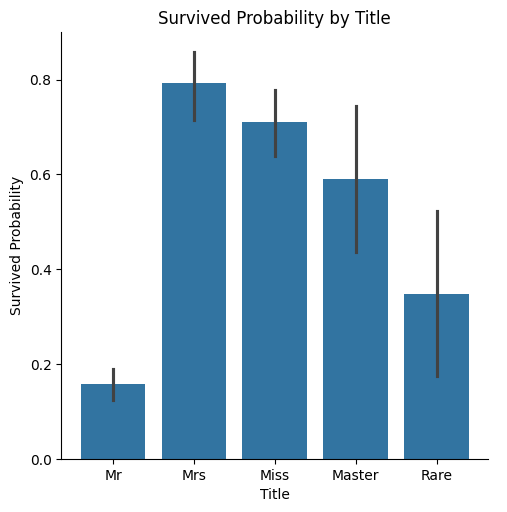

In [77]:
categorical_variables_visualization(df_combine, column_name='Title', target='Survived', visualization='bar')

In [78]:
#Drop the Name column
df_combine =df_combine.drop('Name', axis=1)
df_combine.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss


### Alone Column

In [79]:
df_combine['FamilySize'] = df_combine['SibSp'] + df_combine['Parch'] + 1
df_combine[['SibSp', 'Parch', 'FamilySize']].head(3)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1


In [80]:
df_combine['Alone'] = 0
df_combine.loc[df_combine['FamilySize'] == 1, 'Alone'] = 1

This is the value counts for the column Alone :
Alone
1    790
0    509
Name: count, dtype: int64


------------------------------------------
The mean of the target variable Survived grouped by the categorical column Alone :
   Alone  Survived
0      0  0.514535
1      1  0.303538


------------------------------------------
Creating a bar plot for the Alone column with respect to Survived ...




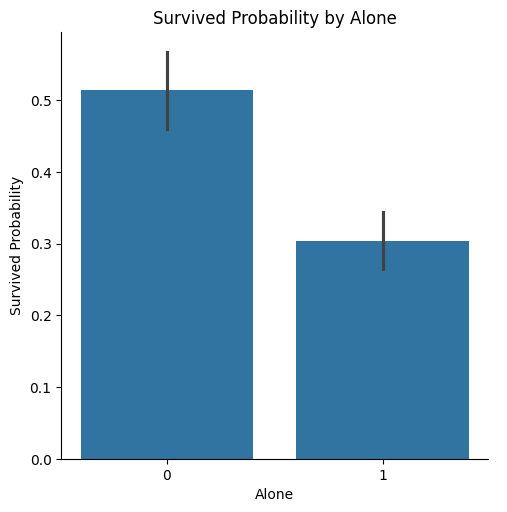

In [81]:
categorical_variables_visualization(df_combine, column_name='Alone', target='Survived', visualization='bar')

### Age Class Column

In [82]:
df_combine['AgeRange'] = pd.cut(df_combine['Age'], 5)
df_combine['AgeRange'].unique()

[(16.136, 32.102], (32.102, 48.068], (48.068, 64.034], (0.0902, 16.136], (64.034, 80.0]]
Categories (5, interval[float64, right]): [(0.0902, 16.136] < (16.136, 32.102] < (32.102, 48.068] < (48.068, 64.034] < (64.034, 80.0]]

In [83]:
df_combine.loc[df_combine['Age'] <= 16.136, 'Age'] = 0
df_combine.loc[(df_combine['Age'] > 16.136) & (df_combine['Age'] <= 32.102), 'Age'] = 1
df_combine.loc[(df_combine['Age'] > 32.102) & (df_combine['Age'] <= 48.068), 'Age'] = 2
df_combine.loc[(df_combine['Age'] > 48.068) & (df_combine['Age'] <= 64.034), 'Age'] = 3
df_combine.loc[df_combine['Age'] > 64.034 , 'Age'] = 4

In [84]:
df_combine.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Alone,AgeRange
0,1,0.0,3,0,1.0,1,0,1.981001,S,Mr,2,0,"(16.136, 32.102]"
1,2,1.0,1,1,2.0,1,0,4.266662,C,Mrs,2,0,"(32.102, 48.068]"
2,3,1.0,3,1,1.0,0,0,2.070022,S,Miss,1,1,"(16.136, 32.102]"
3,4,1.0,1,1,2.0,1,0,3.972177,S,Mrs,2,0,"(32.102, 48.068]"
4,5,0.0,3,0,2.0,0,0,2.085672,S,Mr,1,1,"(32.102, 48.068]"


In [85]:
df_combine = df_combine.drop('AgeRange', axis=1)

In [86]:
df_combine['Age'] = df_combine['Age'].astype('int')
df_combine['Age'].dtype

dtype('int32')

## 5.4 Encoding

Machine Learning models requre numerical input, so categorical features must be `encoded` before model training.

Previously, the Sex column was encoded with 0 representing male and 1 representing female.

Title and Embarked categorical variables will also be encoded into numerical representations. This ensures the model can interpret the information they convey. 

In [87]:
df_combine = pd.get_dummies(df_combine, columns=['Title'])
df_combine = pd.get_dummies(df_combine, columns=['Embarked'], prefix='Emb')
df_combine.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
0,1,0.0,3,0,1,1,0,1.981001,2,0,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,1,0,4.266662,2,0,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,0,0,2.070022,1,1,False,True,False,False,False,False,False,True


#### Fare Column

In [88]:
df_combine['FareRange'] = pd.cut(df_combine['Fare'], 4)
df_combine['FareRange'].unique()

[(1.56, 3.119], (3.119, 4.679], (4.679, 6.239], (-0.00624, 1.56]]
Categories (4, interval[float64, right]): [(-0.00624, 1.56] < (1.56, 3.119] < (3.119, 4.679] < (4.679, 6.239]]

In [89]:
df_combine.loc[df_combine['Fare'] <= 1.56, 'Fare'] = 0
df_combine.loc[(df_combine['Fare'] > 1.56) & (df_combine['Fare'] <= 3.119), 'Fare'] = 1
df_combine.loc[(df_combine['Fare'] > 3.119) & (df_combine['Fare'] <= 4.679), 'Fare'] = 2
df_combine.loc[df_combine['Fare'] > 4.679, 'Fare'] = 3

In [90]:
df_combine = df_combine.drop('FareRange', axis=1)
df_combine.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
0,1,0.0,3,0,1,1,0,1.0,2,0,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,1,0,2.0,2,0,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,0,0,1.0,1,1,False,True,False,False,False,False,False,True


In [91]:
# Separate test and training data frames
train = df_combine[:len(df_train)]
test = df_combine[len(df_train):]

In [92]:
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
0,1,0.0,3,0,1,1,0,1.0,2,0,False,False,True,False,False,False,False,True
1,2,1.0,1,1,2,1,0,2.0,2,0,False,False,False,True,False,True,False,False
2,3,1.0,3,1,1,0,0,1.0,1,1,False,True,False,False,False,False,False,True


In [93]:
train = train.drop('PassengerId', axis=1)
train['Survived'] = train['Survived'].astype('int')

In [94]:
train['Fare'] = train['Fare'].astype('int')

In [95]:
train.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
0,0,3,0,1,1,0,1,2,0,False,False,True,False,False,False,False,True
1,1,1,1,2,1,0,2,2,0,False,False,False,True,False,True,False,False
2,1,3,1,1,0,0,1,1,1,False,True,False,False,False,False,False,True


In [96]:
test.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
881,892,NaN,3,0,2,0,0,1.0,1,1,False,False,True,False,False,False,True,False
882,893,NaN,3,1,2,1,0,1.0,2,0,False,False,False,True,False,False,False,True
883,894,NaN,2,0,3,0,0,1.0,1,1,False,False,True,False,False,False,True,False


In [97]:
test['Fare'] = test['Fare'].astype('int')
test = test.drop('Survived', axis=1)

In [98]:
test.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Emb_C,Emb_Q,Emb_S
881,892,3,0,2,0,0,1,1,1,False,False,True,False,False,False,True,False
882,893,3,1,2,1,0,1,2,0,False,False,False,True,False,False,False,True
883,894,2,0,3,0,0,1,1,1,False,False,True,False,False,False,True,False


# 6. Modelling

Scikit-learn is one of the most widely used libraries for machine learning in Python, and for this project, it will serve as the foundation for our model building process. Given that the Titanic problem is a classification task, where the goal is to predict whether a passenger survived or not, we will by using various classification models to train our model and make predictions.

* Selected Classification Models

For this analysis, i have chosen a diverse set of classification models from the Scikit-learn library to ensure we evaluate multiple approaches to solving the problem. The following models will be tested:

- Logistic Regression - A fundamental classifier for binary classification problems.
- Support Vector Machines (SVM) - A powerful model that works well in high-dimensional spaces.
- K-Nearest Neighbors (KNN) - A simple, instance-based learning algorithm.
- Gaussian Baive Bayes - A probabilistic classifier based on Bayes theorem with the assumption of feature independance.
- Perceptron - A linear Support Vector Classifier for binary classification.
- Linear SVC - A linear Support Vector Classifier for binary classification.
- Stochastic Gradient Descent (SGD): An optimization method for fitting linear classifiers.
- Decision Tree: A non-linear model that makes decisions based on splitting the dataset.
- Random Forest: An ensemble model that builds multiple decision trees and combines their predictions.
- CatBoost: A gradient boosting algorithm that is efficient and handles categorical data well.

In this section of the notebook, I will train each of these classifiers on the Titanic training dataset and evaluate their performance in terms of accuracy on the test set. The model with the highest accuracy will be considered the best performer.

Once the best model is identified, I will perform hyperparameter tuning to further improve the performance. Hyperparameter tuning is an essential step in optimizing a model's performance by finding the most appropriate settings (e.g., learning rate, number of estimators, depth of trees) that yield the best results on unseen data.

By the end of this process, we will have a fully trained and optimized classification model ready to predict the survival status of passengers on the Titanic, and we will have a clear understanding of which machine learning model works best for this task.

In [99]:
X_train = train.drop('Survived', axis=1)
Y_train = train['Survived']

X_test = test.drop('PassengerId', axis=1)

In [100]:
X_train.shape

(881, 16)

In [101]:
Y_train.shape

(881,)

In [102]:
X_test.shape

(418, 16)

In [103]:
def predictions(**kwargs):
    for name, acc in kwargs.items():
        print(f'The model {name} currectly predicted the target variable for {acc} %.')

## Logistic Regression

In [104]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train)* 100, 2)

## Support Vector Machines

In [105]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train)* 100, 2)

## K-nearest Neighbours (KNN)

In [106]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train)*100, 2)

## Gaussian Naive Bayes

In [107]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train)*100, 2)

## Perceptron

In [108]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train)*100, 2)

## Linear SVC

In [109]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

## Stochastic gradient descent

In [110]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

## Decision tree

In [111]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## Random Forest

In [112]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

## CatBoost

In [113]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6880230	total: 68.8ms	remaining: 1m 8s
1:	learn: 0.6825784	total: 70.7ms	remaining: 35.3s
2:	learn: 0.6762832	total: 72ms	remaining: 23.9s
3:	learn: 0.6698090	total: 73.3ms	remaining: 18.3s
4:	learn: 0.6641928	total: 75.2ms	remaining: 15s
5:	learn: 0.6587459	total: 76.8ms	remaining: 12.7s
6:	learn: 0.6532008	total: 78.4ms	remaining: 11.1s
7:	learn: 0.6475088	total: 80ms	remaining: 9.92s
8:	learn: 0.6417892	total: 81.3ms	remaining: 8.96s
9:	learn: 0.6373824	total: 82.5ms	remaining: 8.17s
10:	learn: 0.6319100	total: 83.8ms	remaining: 7.54s
11:	learn: 0.6271331	total: 85.6ms	remaining: 7.05s
12:	learn: 0.6213505	total: 87ms	remaining: 6.61s
13:	learn: 0.6164994	total: 88.4ms	remaining: 6.23s
14:	learn: 0.6119257	total: 90.4ms	remaining: 5.93s
15:	learn: 0.6072060	total: 92ms	remaining: 5.66s
16:	learn: 0.6023159	total: 93.3ms	remaining: 5.4s
17:	learn: 0.5986988	total: 94.5ms	remaining: 5.16s
18:	learn: 0.5958367	total: 96ms	remaining: 4.96s
19:	le

In [114]:
predictions(logreg=acc_log, svc=acc_svc, knn=acc_knn, gaussian=acc_gaussian, perceptron=acc_perceptron, linear_svc=acc_linear_svc, sgd=acc_sgd, decision_tree=acc_decision_tree, random_forest=acc_random_forest, catboost=acc_catboost)

The model logreg currectly predicted the target variable for 82.97 %.
The model svc currectly predicted the target variable for 83.31 %.
The model knn currectly predicted the target variable for 84.34 %.
The model gaussian currectly predicted the target variable for 79.8 %.
The model perceptron currectly predicted the target variable for 79.11 %.
The model linear_svc currectly predicted the target variable for 82.86 %.
The model sgd currectly predicted the target variable for 76.96 %.
The model decision_tree currectly predicted the target variable for 87.74 %.
The model random_forest currectly predicted the target variable for 87.74 %.
The model catboost currectly predicted the target variable for 86.49 %.


# K-fold cross validation

To get a more reliable estimate of model performance, we will use K-fold cross-validation. This technique splits the dataset into K equal parts (or "folds") and trains the model K times, each time using a different fold as the test set while using the remaining K-1 folds for training. The average performance across all K iterations gives a more robust assessment of the model’s ability to generalize to unseen data. By using cross-validation, we can better compare the stability and accuracy of each classifier and ensure that our model is not overfitting to the training data.

In [115]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [116]:
results = []
for classifier in classifiers:
    results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6879037	total: 1.62ms	remaining: 1.62s
1:	learn: 0.6812938	total: 3ms	remaining: 1.5s
2:	learn: 0.6755163	total: 4.4ms	remaining: 1.46s
3:	learn: 0.6703547	total: 5.95ms	remaining: 1.48s
4:	learn: 0.6638106	total: 7.2ms	remaining: 1.43s
5:	learn: 0.6586774	total: 8.5ms	remaining: 1.41s
6:	learn: 0.6524318	total: 9.74ms	remaining: 1.38s
7:	learn: 0.6470582	total: 11ms	remaining: 1.36s
8:	learn: 0.6413263	total: 12.3ms	remaining: 1.35s
9:	learn: 0.6358944	total: 13.7ms	remaining: 1.36s
10:	learn: 0.6323474	total: 14.9ms	remaining: 1.34s
11:	learn: 0.6269133	total: 16.5ms	remaining: 1.36s
12:	learn: 0.6226155	total: 17.7ms	remaining: 1.34s
13:	learn: 0.6174960	total: 19.2ms	remaining: 1.35s
14:	learn: 0.6135811	total: 21.1ms	remaining: 1.39s
15:	learn: 0.6085840	total: 22.9ms	remaining: 1.41s
16:	learn: 0.6046763	total: 24.5ms	remaining: 1.42s
17:	learn: 0.5997597	total: 26.1ms	remaining: 1.43s
18:	learn: 0.5959189	total: 27.7ms	remaining: 1.43s
1

In [117]:
cv_mean = []
cv_std = []

for result in results:
    cv_mean.append(result.mean())
    cv_std.append(result.std())

In [118]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.828588,0.038245,Support Vector Machines
1,0.821770,0.040442,Linear SVC
2,0.819510,0.037557,Logistic Regression
3,0.808184,0.032240,KNN
4,0.805937,0.047625,CatBoost
5,0.794574,0.020982,Random Forest
6,0.793450,0.046345,Gausian Naive Bayes
7,0.783210,0.026048,Decision Tree
8,0.768373,0.032191,Stochastic Gradient Descent
9,0.684653,0.097343,Perceptron


After evaluating all models using K-fold cross-validation, we can compare the models based on their mean accuracy and standard deviation. The models with higher mean accuracy and lower standard deviation are generally more reliable and consistent in their predictions.

    Best Performing Models:
    The Support Vector Machines (SVM), Linear SVC, and Logistic Regression consistently performed well with mean accuracies of approximately 82.85%, 82.17%, and 81.95% respectively, with relatively low standard deviations, indicating stability.

    Most Reliable Models:
    The Support Vector Machines and Linear SVC are very reliable with small standard deviations (0.038 and 0.040, respectively), suggesting they are less prone to overfitting.

    Other Notable Models:
    Random Forest and CatBoost also showed strong performance, with mean accuracies of 79.12% and 80.59%, respectively, and relatively stable performance.

    Models with Higher Variability:
    The Perceptron has the lowest mean accuracy (68.47%) and the highest standard deviation (0.097), indicating that it is not performing well and is highly unstable across different folds.

Recommendation:

Given the results, Support Vector Machines (SVM) or Linear SVC would be the most reliable models to use for making predictions, especially since they not only performed well but also showed consistent results across different folds. If you are looking for slightly better performance, Random Forest or CatBoost are also good alternatives to consider.

After finalizing the best model, we can proceed with hyperparameter tuning to optimize its performance further.

# Hyperparameter tuning for SVM

Hyperparameter tuning is the process of tuning the parameters of a model. Here I will tune the parameters of support vector classifier using GridSearchCV.

In [119]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.780 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.705 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.705 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.676 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.801 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.678 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [120]:
print(grid.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [121]:
# Training accuracy

svc = SVC(C = 1, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.63

In [122]:
cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8183733401430031

In [123]:
Y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [124]:
np.array(df_submission['Survived'])

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [125]:
len(Y_pred)

418

In [128]:
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,1
883,894,0
884,895,0
885,896,1


In [127]:
df_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Here are the performance metrics based on my predictions and the real survival data:

    Accuracy: 95.22% (This is the overall correctness of my predictions.)
    Confusion Matrix:
        True Negatives (TN): 251
        False Positives (FP): 15
        False Negatives (FN): 5
        True Positives (TP): 147
    Precision: 90.74% (This is the percentage of positive predictions that were actually correct.)
    Recall: 96.71% (This is the percentage of actual positives that were correctly predicted.)
    F1-Score: 93.63% (This is the harmonic mean of precision and recall, giving a balance between the two.)

In [129]:
submit.to_csv('data/result.csv', index=False)